In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)


# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Infer Markov Chain transition matrix from political regime time-series data

In [20]:
# load the Polity5 data from the excel data frame
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')

timeSeries = timeSeries[timeSeries["polity2"] != -66]
timeSeries = timeSeries[timeSeries["polity2"] != -88]

In [21]:
nCountries = len(timeSeries['country'].unique()) # numer of countries

In [22]:
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [23]:
# bin the data differently
def addNewBinning(data,numberOfBins,newColumn):

    if numberOfBins == 21:
        print('number of bins not changed')
    elif numberOfBins>21:
        print('number of bins too large')
    elif numberOfBins==3:
        data[newColumn] = round(data['polity2']/7)
    elif numberOfBins==7:
        data[newColumn] = round(data['polity2']/3)
    else:
        print('number of bins not implemented')
    return(data)

    

In [24]:
timeSeries_newBins = addNewBinning(timeSeries,3,'polity2_3bins')
timeSeries_newBins = addNewBinning(timeSeries_newBins,7,'polity2_7bins')

In [25]:
timeSeries_newBins['polity2_3bins'].unique()

array([-1.,  0.,  1.])

## Compute transition matrices

In [28]:
# functions to calculating the transition probabilities

def estimateTransitionMatrix(data,approach='frequentist',column='polity2'):
    
    nStates = len(data[column].unique()) # number of states

    shift = (nStates-1)/2 # shift (maximum amplitude of states)

    # construct some output matrices
    countMatrix=np.zeros((nStates,nStates)) # empty transition matrix
    
    # split the timeseries into one for each country 
    uniqueCountries = data['country'].unique()
    countryTimeseries =[]
    
    # count for each country the transitions
    for country in uniqueCountries:
        sortedPolity2Country = data[data['country'] == country].sort_values(by='year')[column].tolist()
        T=len(sortedPolity2Country)# number of data points
        for t in range(T-1): # go over all years
            fromTransition = int(sortedPolity2Country[t] + shift)
            toTransition = int(sortedPolity2Country[t+1] + shift)
            
            if  (fromTransition>=0) and ((toTransition>=0)):
                
                # increase the count for this year
                countMatrix[fromTransition,toTransition] = countMatrix[fromTransition,toTransition] + 1
    
    if approach=='frequentist':
        # compute the transition probabilities as count over total outgoing
        P = countMatrix/countMatrix.sum(axis=1)[:,None]
    if approach=='bayesian':
        # we use a Dirichlet prior for each row
        priorMatrix = np.zeros((nStates,nStates)) + 1/nStates
        combinedMatrix = countMatrix + priorMatrix
        # this is the posterior mean
        P = combinedMatrix/combinedMatrix.sum(axis=1)[:,None]
    
    return(P)


def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)



In [35]:
P_allCountries_3bins= estimateTransitionMatrix(timeSeries_newBins,approach='bayesian',column='polity2_3bins')
steadyStateEV_3bins = computeSteadyStateEV(P_allCountries_3bins)

P_allCountries_7bins= estimateTransitionMatrix(timeSeries_newBins,approach='bayesian',column='polity2_7bins')
steadyStateEV_7bins = computeSteadyStateEV(P_allCountries_7bins)

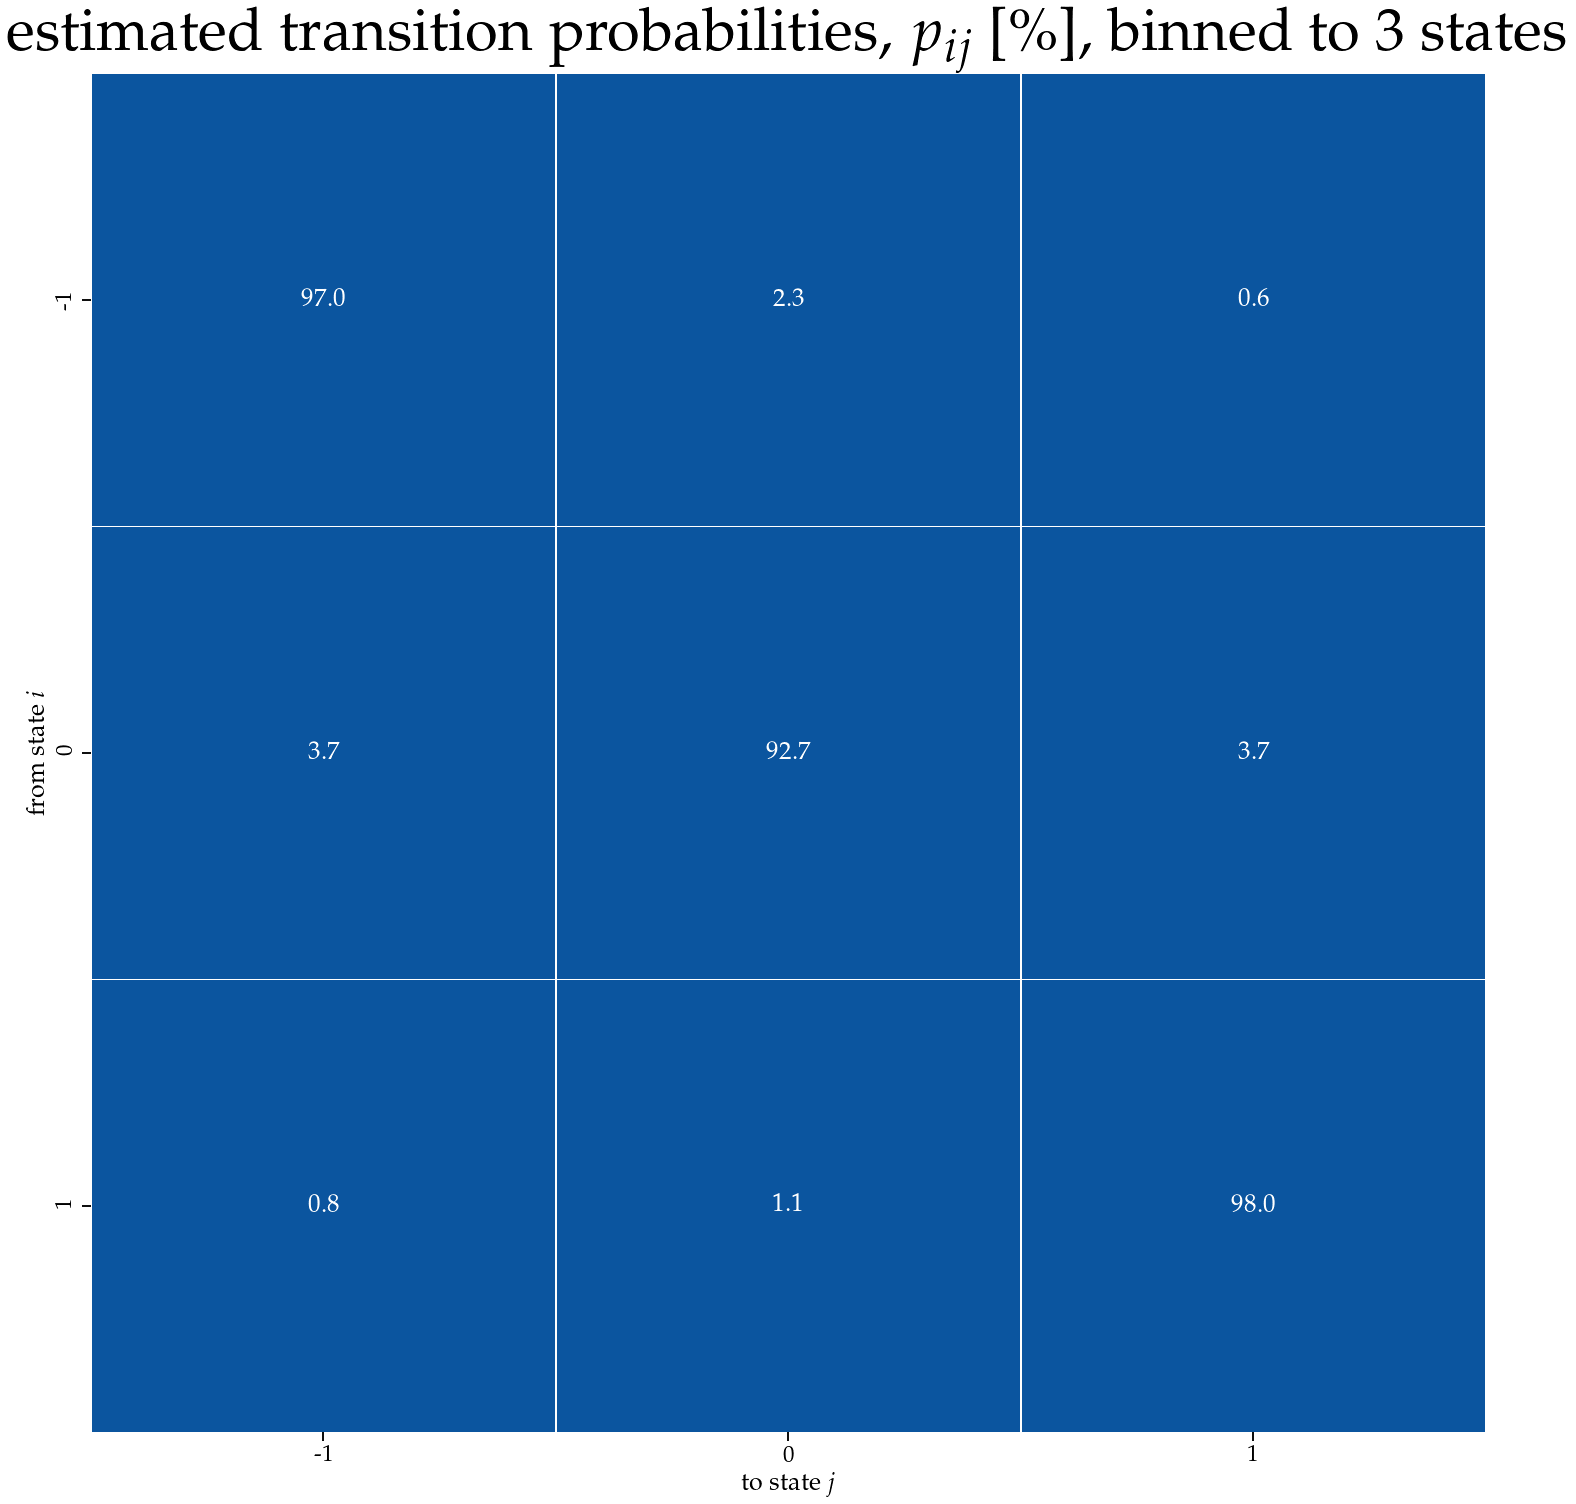

In [70]:
x_axis_labels = np.arange(-1,2,1)
y_axis_labels = np.arange(-1,2,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_3bins*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_3bins.min(), vmax=P_allCountries_3bins.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$], binned to 3 states',size=60)
plt.savefig('./fig/estimatedTransitionProbabilities_3States.pdf',bbox_inches='tight')

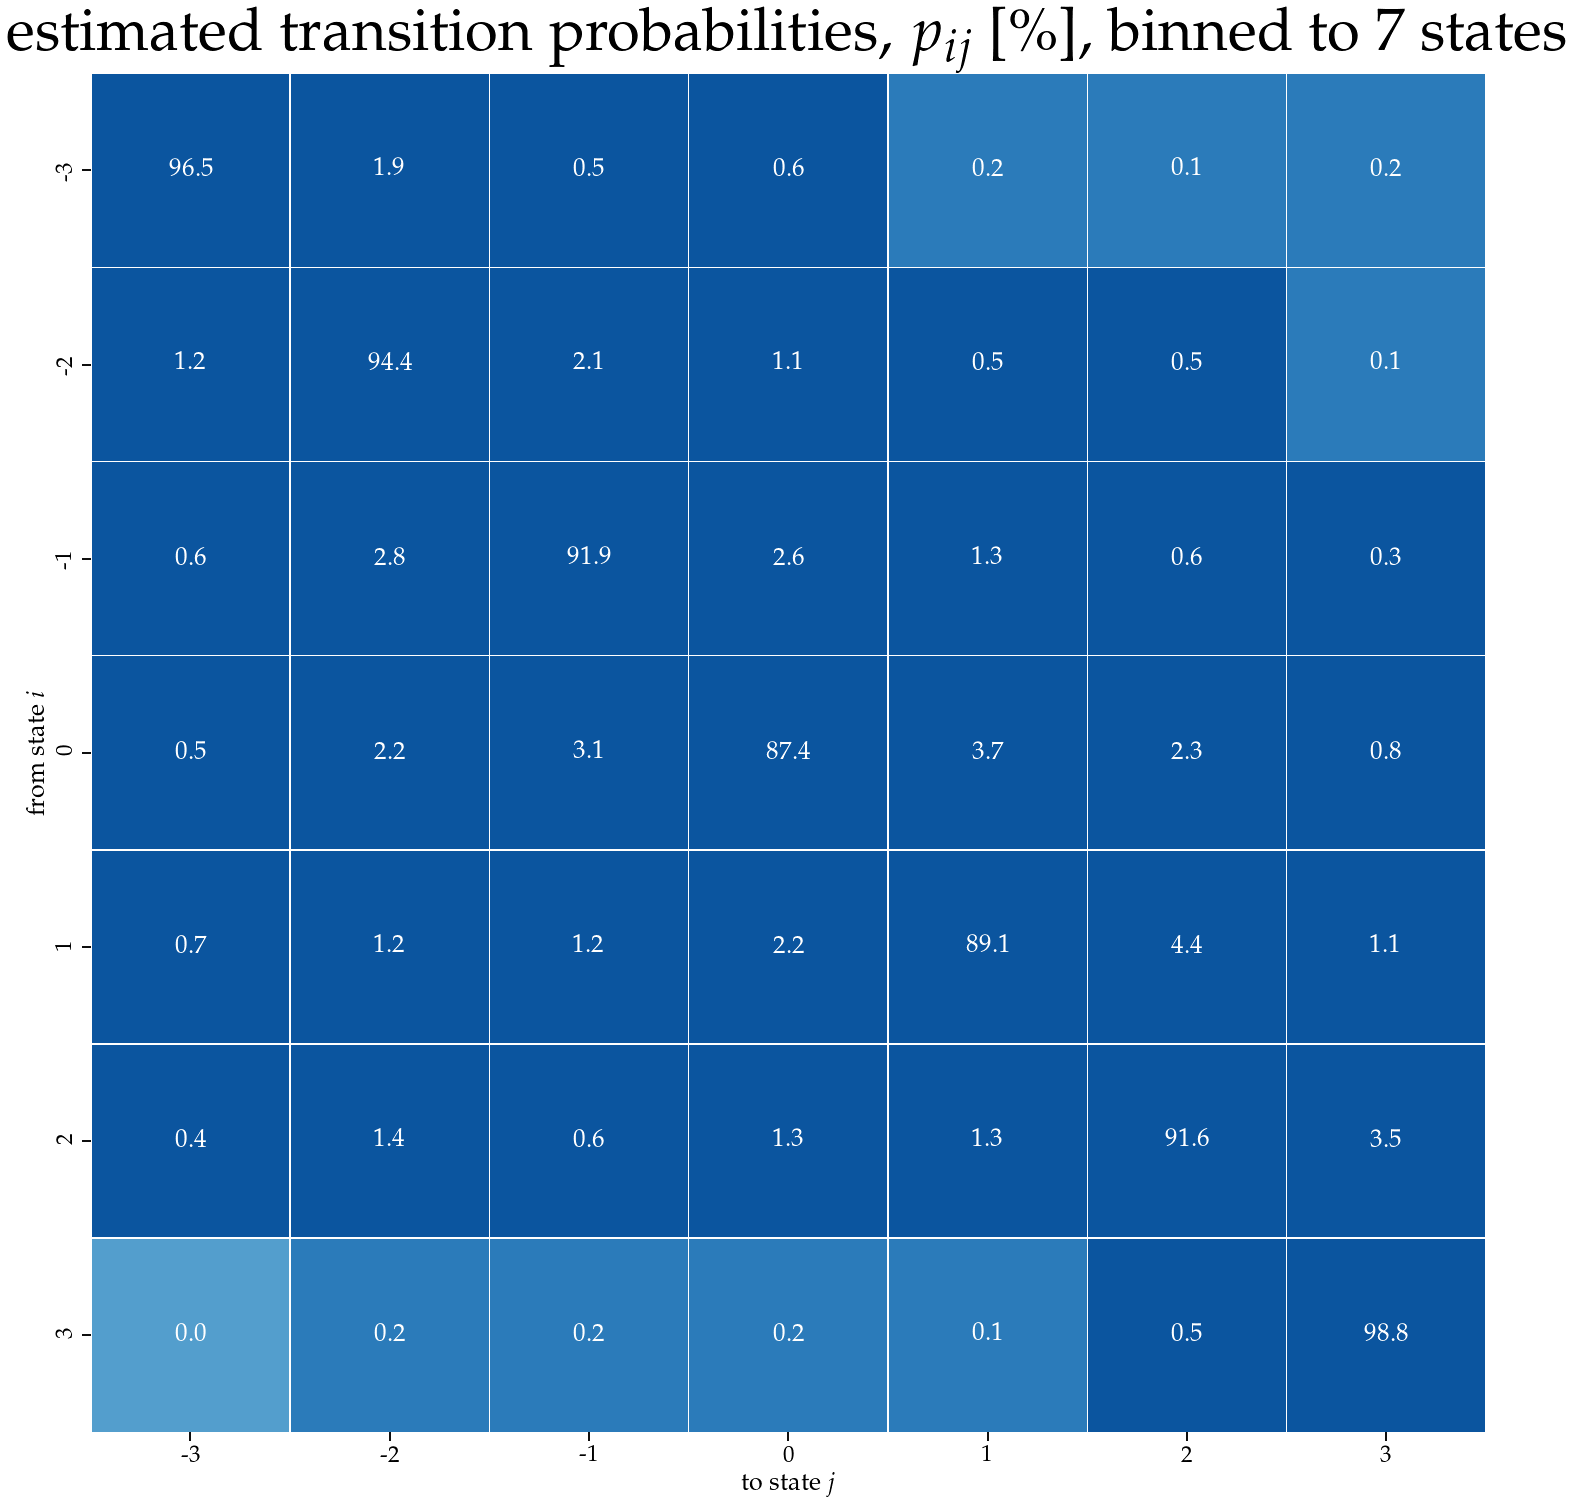

In [69]:
x_axis_labels = np.arange(-3,4,1)
y_axis_labels = np.arange(-3,4,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_7bins*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_7bins.min(), vmax=P_allCountries_7bins.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$], binned to 7 states',size=60)
plt.savefig('./fig/estimatedTransitionProbabilities_7States.pdf',bbox_inches='tight')

### Plot the end of history

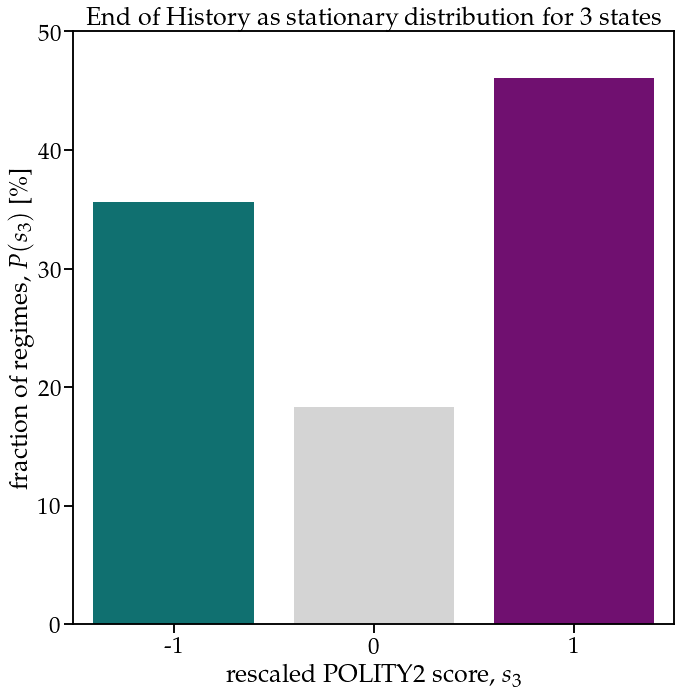

In [80]:
# plot the steady state
plt.figure(figsize=(10,10))
steadyState=pd.DataFrame()
steadyState['fraction'] = 100*steadyStateEV_3bins
steadyState['regime'] = np.arange(-1,2,1)

teal = [0,0.5,0.5]
lightgray = [0.83,0.83,0.83]
purple = [0.5,0.0,0.5]

clrs = [teal,lightgray,purple]
clrs1 = np.linspace(teal, lightgray, 1, axis=1)
clrs2 = np.linspace(lightgray, purple, 2, axis=1)

clrs = np.concatenate((clrs1,clrs2), axis=1)

clrsL = np.transpose(clrs).tolist()


g=sns.barplot(x="regime", y="fraction", data=steadyState,palette=clrsL)

plt.ylim([0,50])


# plt.legend(loc=0)
plt.tight_layout()
plt.title('End of History as stationary distribution for 3 states')
plt.xlabel(r'rescaled POLITY2 score, $s_3$')
plt.ylabel(r'fraction of regimes, $P(s_3)$ [$\%$]')
plt.savefig('./fig/distributionAndSteadyStateBarplot_3States.pdf',bbox_inches='tight')

#plt.savefig('./figures/distributionAndSteadyStateBarplot.pdf')
#plt.savefig('./../results/figures/Fig4-distributionAndSteadyStateBarplot.pdf',bbox_inches='tight')




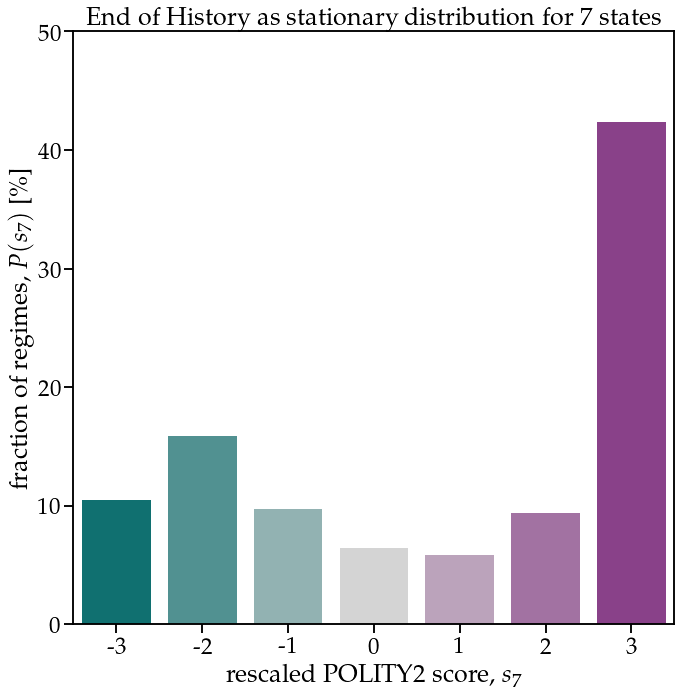

In [79]:
# plot the steady state
plt.figure(figsize=(10,10))
steadyState=pd.DataFrame()
steadyState['fraction'] = 100*steadyStateEV_7bins
steadyState['regime'] = np.arange(-3,4,1)

teal = [0,0.5,0.5]
lightgray = [0.83,0.83,0.83]
purple = [0.5,0.0,0.5]

clrs = [teal,lightgray,purple]
clrs1 = np.linspace(teal, lightgray, 4, axis=1)
clrs2 = np.linspace(lightgray, purple, 5, axis=1)

clrs = np.concatenate((clrs1,clrs2[:,1:-1]), axis=1)

clrsL = np.transpose(clrs).tolist()


g=sns.barplot(x="regime", y="fraction", data=steadyState,palette=clrsL)

plt.ylim([0,50])

# plt.legend(loc=0)
plt.tight_layout()
plt.title('End of History as stationary distribution for 7 states')
plt.xlabel(r'rescaled POLITY2 score, $s_7$')
plt.ylabel(r'fraction of regimes, $P(s_7)$ [$\%$]')
plt.savefig('./fig/distributionAndSteadyStateBarplot_7States.pdf',bbox_inches='tight')


#plt.savefig('./figures/distributionAndSteadyStateBarplot.pdf')
#plt.savefig('./../results/figures/Fig4-distributionAndSteadyStateBarplot.pdf',bbox_inches='tight')




In [75]:
np.sum(steadyStateEV_3bins*np.arange(-1,2,1))

0.10430983436453517

In [77]:
np.sum(steadyStateEV_7bins*np.arange(-3,+4,1))

0.7876032674787773

In [78]:
steadyStateEV_7bins*np.arange(-3,+4,1)

array([-0.31349292, -0.31717327, -0.0973458 ,  0.        ,  0.05803716,
        0.18745324,  1.27012486])